In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import numpy as np
import tensorflow_probability as tfp

In [ ]:
class PolicyNet():
    def __init__(self, input_size, output_size):
        self.model = keras.Sequential(
            layers=[
                tf.keras.Input(shape=(input_size,)),
                layers.Dense(64, activation="relu", name="relu_layer"),
                layers.Dense(output_size, activation="linear", name="linear_layer")
            ],
            name="policy")

    def action_distribution(self, observations):
        logits = self.model(observations)
        return tfp.distributions.Categorical(logits=logits)

    def sampel_action(self, observations):
        sampled_actions = self.action_distribution(observations).sample().numpy()
        return sampled_actions

class BaselineNet():
    def __init__(self, input_size, output_size):
        self.model = keras.Sequential(
            layers=[
                keras.Input(shape=(input_size,)),
                layers.Dense(64, activation="relu", name="relu_layer"),
                layers.Dense(output_size, activation="linear", name="linear_layer")
            ],
            name="baseline")
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=3e-2)

    def forward(self, observations):
        output = tf.squeeze(self.model(observations))
        return output

    def update(self, observations, target):
        with tf.GradientTape() as tape:
            predictions = self.forward(observations)
            loss = tf.keras.losses.mean_squared_error(y_true=target, y_pred=predictions)
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

class PolicyGradient(object):
    def __init__(self, env, num_iterations=300, batch_size=2000, max_ep_len=200, output_path="../results/"):
        self.output_path = output_path
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        self.env = env
        self.observation_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.gamma = 0.9
        self.num_iterations = num_iterations
        self.batch_size = batch_size
        self.max_ep_len = max_ep_len
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=3e-2)
        self.policy_net = PolicyNet(input_size=self.observation_dim, output_size=self.action_dim)
        self.baseline_net = BaselineNet(input_size=self.observation_dim, output_size=1)

        
    def train(self):
        all_total_rewards = []
        averaged_total_rewards = []
        for t in range(self.num_iterations):
            paths, total_rewards = self.play_games()
            all_total_rewards.extend(total_rewards)
            observations = np.concatenate([path["observation"] for path in paths])
            actions = np.concatenate([path["action"] for path in paths])
            returns = self.get_returns(paths)
            advantages = self.get_advantage(returns, observations)
            self.baseline_net.update(observations=observations, target=returns)
            self.update_policy(observations, actions, advantages)
            avg_reward = np.mean(total_rewards)
            averaged_total_rewards.append(avg_reward)
            print("Average reward for batch {}: {:04.2f}".format(t,avg_reward))
        print("Training complete")
        np.save(self.output_path+ "rewards.npy", averaged_total_rewards)
        export_plot(averaged_total_rewards, "Reward", "CartPole-v0", self.output_path + "rewards.png")

       
    def play_games(self, env=None, num_episodes = None):
        episode = 0
        episode_rewards = []
        paths = []
        t = 0
        if not env:
            env = self.env

        while (num_episodes or t < self.batch_size):
            state = env.reset()
            states, actions, rewards = [], [], []
            episode_reward = 0

            for step in range(self.max_ep_len):
                states.append(state)
                action = self.policy_net.sampel_action(np.atleast_2d(state))[0]
                state, reward, done, _ = env.step(action)
                actions.append(action)
                rewards.append(reward)
                episode_reward += reward
                t += 1

                if (done or step == self.max_ep_len-1):
                    episode_rewards.append(episode_reward)
                    break
                if (not num_episodes) and t == self.batch_size:
                    break

            path = {"observation": np.array(states),
                    "reward": np.array(rewards),
                    "action": np.array(actions)}
            paths.append(path)
            episode += 1
            if num_episodes and episode >= num_episodes:
                break
        return paths, episode_rewards

    def evall(self, env, num_episodes=1):
        paths, rewards = self.play_games(env, num_episodes)
        avg_reward = np.mean(rewards)
        print("Average eval reward: {:04.2f}".format(avg_reward))
        return avg_reward

    def make_video(self):
        env = wrappers.Monitor(self.env, self.output_path+"videos", force=True)
        self.evall(env=env, num_episodes=1)
        
    def get_returns(self, paths):
        all_returns = []
        for path in paths:
            rewards = path["reward"]
            returns = []
            reversed_rewards = np.flip(rewards,0)
            g_t = 0
            for r in reversed_rewards:
                g_t = r + self.gamma*g_t
                returns.insert(0, g_t)
            all_returns.append(returns)
        returns = np.concatenate(all_returns)
        return returns
    
    def get_advantage(self, returns, observations):
            values = self.baseline_net.forward(observations).numpy()
            advantages = returns - values
            advantages = (advantages-np.mean(advantages)) / np.sqrt(np.sum(advantages**2))
            return advantages

    def update_policy(self, observations, actions, advantages):
            observations = tf.convert_to_tensor(observations)
            actions = tf.convert_to_tensor(actions)
            advantages = tf.convert_to_tensor(advantages)
            with tf.GradientTape() as tape:
                log_prob = self.policy_net.action_distribution(observations).log_prob(actions)
                loss = -tf.math.reduce_mean(log_prob * tf.cast(advantages, tf.float32))
            grads = tape.gradient(loss, self.policy_net.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.policy_net.model.trainable_weights))


In [ ]:
env = gym.make("CartPole-v0")
model = PolicyGradient(env)
model.train()
model.make_video()

Average reward for batch 0: 22.98
Average reward for batch 1: 37.47
Average reward for batch 2: 45.39
Average reward for batch 3: 53.92
Average reward for batch 4: 73.70
Average reward for batch 5: 71.39
Average reward for batch 6: 80.67
Average reward for batch 7: 102.42
Average reward for batch 8: 135.21
Average reward for batch 9: 167.00
Average reward for batch 10: 181.36
Average reward for batch 11: 177.45
Average reward for batch 12: 176.36
Average reward for batch 13: 198.20
Average reward for batch 14: 200.00
Average reward for batch 15: 195.90
Average reward for batch 16: 200.00
Average reward for batch 17: 196.40
Average reward for batch 18: 200.00
Average reward for batch 19: 198.10
Average reward for batch 20: 200.00
Average reward for batch 21: 200.00
Average reward for batch 22: 200.00
Average reward for batch 23: 200.00
Average reward for batch 24: 183.70
Average reward for batch 25: 198.70
Average reward for batch 26: 174.64
Average reward for batch 27: 176.09
Average r

NameError: ignored

In [ ]:
dic={    0: 22.98,
    1: 37.47,
    2: 45.39,
    3: 53.92,
    4: 73.70,
    5: 71.39,
    6: 80.67,
    7: 102.42,
    8: 135.21,
    9: 167.00,
    10: 181.36,
    11: 177.45,
    12: 176.36,
    13: 198.20,
    14: 200.00,
    15: 195.90,
    16: 200.00,
    17: 196.40,
    18: 200.00,
    19: 198.10,
    20: 200.00,
    21: 200.00,
    22: 200.00,
    23: 200.00,
    24: 183.70,
    25: 198.70,
    26: 174.64,
    27: 176.09,
    28: 180.36,
    29: 200.00,
    30: 190.40,
    31: 197.60,
    32: 200.00,
    33: 197.00,
    34: 193.50,
    35: 200.00,
    36: 199.80,
    37: 200.00,
    38: 200.00,
    39: 197.00,
    40: 200.00,
    41: 168.27,
    42: 115.82,
    43: 82.67,
    44: 94.19,
    45: 109.39,
    46: 122.94,
    47: 134.86,
    48: 144.77,
    49: 152.75,
    50: 166.33,
    51: 188.90,
    52: 190.80,
    53: 190.00,
    54: 200.00,
    55: 200.00,
    56: 200.00,
    57: 200.00,
    58: 200.00,
    59: 200.00,
    60: 200.00,
    61: 200.00,
    62: 200.00,
    63: 200.00,
    64: 200.00,
    65: 200.00,
    66: 200.00,
    67: 200.00,
    68: 200.00,
    69: 200.00,
    70: 200.00,
    71: 200.00,
    72: 200.00,
    73: 200.00,
    74: 200.00,
    75: 200.00,
    76: 200.00,
    77: 200.00,
    78: 200.00,
    79: 200.00,
    80: 200.00,
    81: 200.00,
    82: 200.00,
    83: 200.00,
    84: 200.00,
    85: 200.00,
    86: 200.00,
    87: 200.00,
    88: 200.00,
    89: 200.00,
    90: 200.00,
    91: 200.00,
    92: 198.70,
    93: 197.80,
    94: 191.70,
    95: 161.25,
    96: 146.77,
    97: 131.13,
    98: 114.47,
    99: 110.44,
    100: 110.28,
    101: 103.79,
    102: 99.75,
    103: 110.28,
    104: 108.50,
    105: 113.59,
    106: 109.11,
    107: 110.11,
    108: 110.78,
    109: 113.06,
    110: 115.12,
    111: 115.94,
    112: 113.65,
    113: 112.82,
    114: 117.29,
    115: 115.47,
    116: 108.94,
    117: 109.06,
    118: 110.11,
    119: 111.24,
    120: 105.11,
    121: 93.10,
    122: 104.79,
    123: 112.65,
    124: 114.94,
    125: 114.94,
    126: 117.94,
    127: 117.65,
    128: 116.59,
    129: 114.24,
    130: 113.71,
    131: 115.59,
    132: 118.12,
    133: 118.88,
    134: 124.06,
    135: 124.75,
    136: 125.73,
    137: 124.69,
    138: 128.20,
    139: 123.12,
    140: 120.38,
    141: 118.38,
    142: 118.69,
    143: 117.94,
    144: 118.88,
    145: 111.94,
    146: 110.50,
    147: 109.22,
    148: 108.56,
    149: 108.78,
    150: 114.94,
    151: 114.88,
    152: 117.62,
    153: 127.00,
    154: 132.67,
    155: 140.43,
    156: 149.46,
    157: 165.08,
    158: 180.27,
    159: 189.90,
    160: 198.00,
    161: 200.00,
    162: 200.00,
    163: 200.00,
    164: 200.00,
    165: 200.00,
    166: 200.00,
    167: 200.00,
    168: 200.00,
    169: 200.00,
    170: 200.00,
    171: 200.00,
    172: 200.00,
    173: 200.00,
    174: 200.00,
    175: 200.00,
    176: 200.00,
    177: 200.00,
    178: 200.00,
    179: 200.00,
    180: 200.00,
    181: 200.00,
    182: 200.00,
    183: 200.00,
    184: 200.00,
    185: 200.00,
    186: 200.00,
    187: 200.00,
    188: 200.00,
    189: 200.00,
    190: 200.00,
    191: 200.00,
    192: 200.00,
    193: 200.00,
    194: 200.00,
    195: 200.00,
    196: 200.00,
    197: 200.00,
    198: 200.00,
    199: 200.00,
    200: 200.00,
    201: 200.00,
    202: 200.00,
    203: 200.00,
    204: 200.00,
    205: 200.00,
    206: 200.00,
    207: 200.00,
    208: 200.00,
    209: 200.00,
    210: 200.00,
    211: 200.00,
    212: 200.00,
    213: 200.00,
    214: 200.00,
    215: 200.00,
    216: 200.00,
    217: 200.00,
    218: 200.00,
    219: 200.00,
    220: 200.00,
    221: 200.00,
    222: 200.00,
    223: 200.00,
    224: 200.00,
    225: 200.00,
    226: 200.00,
    227: 200.00,
    228: 200.00,
    229: 200.00,
    230: 200.00,
    231: 200.00,
    232: 200.00,
    233: 200.00,
    234: 200.00,
    235: 200.00,
    236: 200.00,
    237: 200.00,
    238: 200.00,
    239: 200.00,
    240: 200.00,
    241: 200.00,
    242: 200.00,
    243: 200.00,
    244: 200.00,
    245: 200.00,
    246: 200.00,
    247: 200.00,
    248: 200.00,
    249: 200.00,
    250: 200.00,
    251: 200.00,
    252: 200.00,
    253: 200.00,
    254: 200.00,
    255: 200.00,
    256: 200.00,
    257: 200.00,
    258: 200.00,
    259: 200.00,
    260: 200.00,
    261: 200.00,
    262: 200.00,
    263: 200.00,
    264: 200.00,
    265: 200.00,
    266: 200.00,
    267: 200.00,
    268: 200.00,
    269: 200.00,
    270: 200.00,
    271: 200.00,
    272: 200.00,
    273: 200.00,
    274: 200.00,
    275: 200.00,
    276: 200.00,
    277: 200.00,
    278: 200.00,
    279: 193.70,
    280: 181.20,
    281: 200.00,
    282: 193.40,
    283: 200.00,
    284: 200.00,
    285: 200.00,
    286: 197.00,
    287: 195.30,
    288: 200.00,
    289: 200.00,
    290: 199.00,
    291: 199.30,
    292: 200.00,
    293: 200.00,
    294: 200.00,
    295: 200.00,
    296: 200.00,
    297: 200.00,
    298: 200.00,
    299: 200.00}

In [ ]:
val=[]
for i,j in dic.items():
  val.append(j)

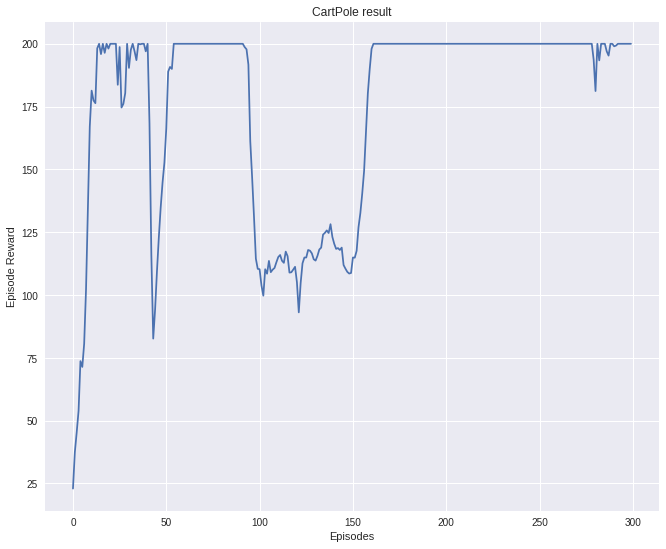

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, (ax1) = plt.subplots(1)
ax1.plot(val)
ax1.set_ylabel('Episode Reward')
ax1.set_xlabel('Episodes')
ax1.set_title('CartPole result')
fig.set_figwidth(11)
fig.set_figheight(9)
plt.savefig('CartPole results')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                320       
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385
Trainable params: 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0 score: 9.0
episode: 1 score: 17.0
episode: 2 score: 8.0
episode: 3 score: 11.0
episode: 4 score: 8.0
episode: 5 score: 9.0
episode: 6 score: 18.0
episode: 7 score: 8.0
episode: 8 score: 10.0
episode: 9 score: 12.0
episode: 10 score: 10.0
episode: 11 score: 10.0
episode: 12 score: 15.0
episode: 13 score: 10.0
episode: 14 score: 10.0
episode: 15 score: 18.0
episode: 16 score: 14.0
episode: 17 score: 8.0
episode: 18 score: 53.0
episode: 19 score: 18.0
episode: 20 score: 9.0
episode: 21 score: 14.0
episode: 22 score: 15.0
episode: 23 score: 70.0
episode: 24 score: 12.0
episode: 25 score: 46.0
episode: 26 score: 13.0
episode: 27 score: 16.0
episode: 28 score: 13.0
episode: 29 score: 34.0
episode: 30 score: 15.0
episode: 31 score: 25.0
episode: 32 score: 24.0
episode: 33 score: 10.0
episode: 34 score: 27.0
episode: 35 score: 15.0
episode: 36 score: 30.0
episode: 37 score: 21.0
episode: 38 score: 40.0
episode: 39 score: 19.0
episode: 40 score: 53.0
episode: 41 score: 17.0
episode: 

KeyboardInterrupt: ignored

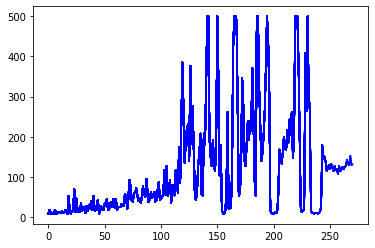

In [2]:

'''
NOTE:
This is an implementation of the Advantage actor-critic agent for Cartpole.
The main source for this one would be in this repo: https://github.com/rlcode/reinforcement-learning/blob/master/2-cartpole/4-actor-critic/cartpole_a2c.py
This was done by rlcode guys, similar to the one that gave us DQN-Cartpole earlier.
'''

# Import dependencies

import sys
import gym
import pylab
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#NOTE: Start of the Cartpole Agent using A2C (Advantage Actor-Critic)
class A2CAgent:
    def __init__(self, state_size, action_size,nodes):
        self.render = False # For rendering the cartpole model
        self.load_model = False # Set if you want to load a previous checkpoint
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.nodes = nodes

        # Policy Gradient hyperparameters
        # NOTE: Read more on Policy Gradient

        self.discount_factor = 0.99 # For the entire update statement
        self.actor_lr = 0.001 # For the Optimizer of Actor
        self.critic_lr = 0.005 # Why is it higher? For stability?

        # Call the building blocks
        self.actor = self.build_actor()
        self.critic = self.build_critic()

       
    # We then create the Neural Network for the approximation of the actor and critic values
    # i.e. policy and value for the model.

    # NOTE: Actor module: Input of states and outputs the probability of an action (softmax)
    def build_actor(self):
        actor = Sequential() # Define our model
        actor.add(Dense(self.nodes , input_dim = self.state_size, activation= 'relu', kernel_initializer= 'he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',kernel_initializer='he_uniform'))
        actor.summary()
        actor.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = self.actor_lr))
        return actor
    # NOTE: Critic module: Input is also state but the output is also state(linear)
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(self.nodes, input_dim = self.state_size, activation= 'relu', kernel_initializer= 'he_uniform'))
        critic.add(Dense(self.value_size,activation= 'linear', kernel_initializer= 'he_uniform'))
        critic.summary()
        critic.compile(loss = 'mse', optimizer= Adam(lr=self.critic_lr))# Loss is MSE since we want to give out a value and not a probability.
        return critic
    # NOTE: We do the function on how the agent will pick the next action and policy based on stochastics(probability)
    def get_action(self,state):
        policy = self.actor.predict(state,batch_size=1).flatten()
        return np.random.choice(self.action_size,1,p=policy)[0]
    # NOTE: We do the update for the network policy.
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1,self.value_size)) # Initialize the policy targets matrix
        advantages = np.zeros((1,self.action_size)) # Initialize the advantages matrix

        value = self.critic.predict(state)[0] # Get value for this state
        next_value = self.critic.predict(next_state)[0] # Get value for the next state

        # update the advantages and value tables if done
        if done:
            advantages[0][action] = reward - value # Basically, what do we gain by choosing the action, will it improve or worsen the advantage
            target[0][0] = reward # Fill in the target value to see if we can still improve it in the policy making
        else:
            advantages[0][action] = reward + self.discount_factor*(next_value) - value # If not yet done, then simply update for the current step.
            target[0][0] = reward + self.discount_factor*next_value
        # Once we are done with the episode, we then update the weights
        self.actor.fit(state,advantages,epochs=1,verbose=0)
        self.critic.fit(state,target,epochs=1,verbose=0)

class A2C_train:
    def __init__(self, episodes,nodes):
        self.Episodes = episodes
        self.nodes = nodes
        if __name__ == '__main__':
            # TODO: Create an environment
            env = gym.make('CartPole-v1')
            # TODO: Get the action and state sizes
            state_size = env.observation_space.shape[0]
            action_size = env.action_space.n
            # TODO: Make the agent by calling the function earlier
            agent = A2CAgent(state_size,action_size,self.nodes)
            # TODO: Initialize our scores and episodes list
            scores, episodes = [], []

            # TODO: Create the training loop
            for e in range(self.Episodes):
                done = False
                score = 0
                state = env.reset()
                state = np.reshape(state,[1,state_size])

                while not done:
                    # Check if we want to render
                    if agent.render:
                        env.render()
                    action = agent.get_action(state)
                    next_state, reward, done, info = env.step(action)
                    next_state = np.reshape(next_state,[1,state_size])
                    # Give immediate penalty for an action that terminates the episode immediately, Since we want to maximize the time
                    # Note that the max for the cartpole is 499 and it will reset, otherwise we keep the current score if it is not yet done, and if it ended we give a -100 reward
                    reward = reward if not done or score == 499 else -100
                    # We now train the model based on the results of our action taken
                    agent.train_model(state,action,reward,next_state,done)
                    score += reward
                    state = next_state

                    if done:
                        score = score if score == 500.0 else score +100
                        scores.append(score)
                        episodes.append(e)
                        pylab.plot(episodes,scores,'b')
                        if np.mean(scores[-min(10, len(scores)):]) > 490:
                            sys.exit()
                if e % 1 ==0:
     
                    print("episode: {} score: {}".format(e,score))
        
        
A2C_train(300,64)

In [4]:
dic={0: 9.0,
1: 17.0,
2: 8.0,
3: 11.0,
4: 8.0,
5: 9.0,
6: 18.0,
7: 8.0,
8: 10.0,
9: 12.0,
10: 10.0,
11: 10.0,
12: 15.0,
13: 10.0,
14: 10.0,
15: 18.0,
16: 14.0,
17: 8.0,
18: 53.0,
19: 18.0,
20: 9.0,
21: 14.0,
22: 15.0,
23: 70.0,
24: 12.0,
25: 46.0,
26: 13.0,
27: 16.0,
28: 13.0,
29: 34.0,
30: 15.0,
31: 25.0,
32: 24.0,
33: 10.0,
34: 27.0,
35: 15.0,
36: 30.0,
37: 21.0,
38: 40.0,
39: 19.0,
40: 53.0,
41: 17.0,
42: 17.0,
43: 30.0,
44: 42.0,
45: 8.0,
46: 19.0,
47: 26.0,
48: 19.0,
49: 19.0,
50: 32.0,
51: 35.0,
52: 45.0,
53: 18.0,
54: 20.0,
55: 34.0,
56: 37.0,
57: 26.0,
58: 45.0,
59: 22.0,
60: 45.0,
61: 18.0,
62: 25.0,
63: 25.0,
64: 25.0,
65: 32.0,
66: 28.0,
67: 28.0,
68: 58.0,
69: 53.0,
70: 20.0,
71: 46.0,
72: 92.0,
73: 75.0,
74: 41.0,
75: 39.0,
76: 59.0,
77: 61.0,
78: 71.0,
79: 55.0,
80: 40.0,
81: 47.0,
82: 36.0,
83: 48.0,
84: 76.0,
85: 58.0,
86: 51.0,
87: 95.0,
88: 64.0,
89: 37.0,
90: 45.0,
91: 61.0,
92: 47.0,
93: 55.0,
94: 63.0,
95: 39.0,
96: 42.0,
97: 68.0,
98: 86.0,
99: 44.0,
100: 45.0,
101: 50.0,
102: 56.0,
103: 117.0,
104: 56.0,
105: 127.0,
106: 52.0,
107: 65.0,
108: 92.0,
109: 36.0,
110: 61.0,
111: 79.0,
112: 54.0,
113: 116.0,
114: 85.0,
115: 61.0,
116: 173.0,
117: 86.0,
118: 230.0,
119: 385.0,
120: 257.0,
121: 135.0,
122: 193.0,
123: 220.0,
124: 232.0,
125: 139.0,
126: 377.0,
127: 182.0,
128: 276.0,
129: 172.0,
130: 56.0,
131: 42.0,
132: 67.0,
133: 130.0,
134: 158.0,
135: 208.0,
136: 57.0,
137: 54.0,
138: 209.0,
139: 180.0,
140: 329.0,
141: 500.0,
142: 500.0,
143: 195.0,
144: 151.0,
145: 127.0,
146: 192.0,
147: 122.0,
148: 116.0,
149: 220.0,
150: 500.0,
151: 328.0,
152: 103.0,
153: 180.0,
154: 16.0,
155: 9.0,
156: 9.0,
157: 16.0,
158: 57.0,
159: 261.0,
160: 21.0,
161: 22.0,
162: 23.0,
163: 111.0,
164: 421.0,
165: 500.0,
166: 500.0,
167: 490.0,
168: 272.0,
169: 52.0,
170: 63.0,
171: 119.0,
172: 345.0,
173: 277.0,
174: 143.0,
175: 127.0,
176: 182.0,
177: 239.0,
178: 192.0,
179: 238.0,
180: 214.0,
181: 371.0,
182: 244.0,
183: 93.0,
184: 54.0,
185: 500.0,
186: 500.0,
187: 327.0,
188: 232.0,
189: 140.0,
190: 160.0,
191: 202.0,
192: 264.0,
193: 369.0,
194: 500.0,
195: 445.0,
196: 318.0,
197: 16.0,
198: 10.0,
199: 9.0,
200: 9.0,
201: 12.0,
202: 10.0,
203: 12.0,
204: 54.0,
205: 168.0,
206: 145.0,
207: 133.0,
208: 160.0,
209: 200.0,
210: 172.0,
211: 167.0,
212: 216.0,
213: 186.0,
214: 243.0,
215: 205.0,
216: 262.0,
217: 148.0,
218: 191.0,
219: 500.0,
220: 500.0,
221: 500.0}

In [8]:
val=[]
for i,j in dic.items():
  if j>200:
    j=200
  val.append(j)

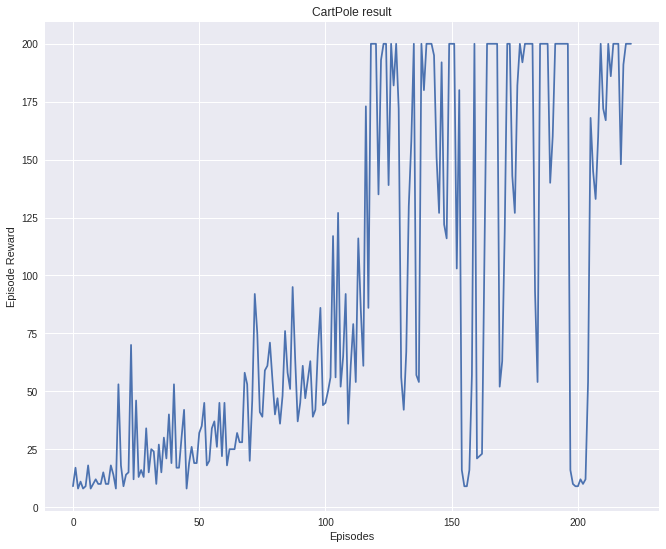

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, (ax1) = plt.subplots(1)
ax1.plot(val)
ax1.set_ylabel('Episode Reward')
ax1.set_xlabel('Episodes')
ax1.set_title('CartPole result')
fig.set_figwidth(11)
fig.set_figheight(9)
plt.savefig('CartPole results 3')
plt.show()